In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [4]:
# Load data
df = pd.read_csv('../data/processed/cleaned_data_20240621_143909.csv')

In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Remove a specific column
df = df.drop('Unnamed: 0', axis=1)

In [6]:
#summary of the age column
df['age'].describe()

count    100000.00000
mean         43.57069
std           4.86376
min          21.00000
25%          40.00000
50%          44.00000
75%          47.00000
max          65.00000
Name: age, dtype: float64

In [7]:
#Bining the age column into age groups 

# Define bins for age groups
bins = [0, 18, 30, 40, 50, float('inf')]  # Example bins, adjust as needed
labels = ['0-18', '19-30', '31-40', '41-50', '51+']

# Create age_group column using pd.cut
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df[['age', 'age_group']].head()


,age,age_group
0,37,31-40
1,43,41-50
2,43,41-50
3,47,41-50
4,42,41-50


In [8]:
#summary of the salary column
df['salary'].describe()

count    100000.000000
mean       2781.804324
std         696.450055
min         250.000000
25%        2273.929349
50%        2665.441567
75%        3146.577655
max       10000.000000
Name: salary, dtype: float64

In [9]:


# Define bins and labels based on the summary statistics
salary_bins = [0, 2273.93, 2665.44, 3146.58, 10000]  # Adjusted bins based on quartiles and max salary
salary_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Create salary_group column using pd.cut
df['salary_group'] = pd.cut(df['salary'], bins=salary_bins, labels=salary_labels, right=False)

df[['salary','salary_group']].head()

,salary,salary_group
0,3230.038869,High
1,3194.139103,High
2,3330.826656,High
3,2246.797020,Low
4,2310.858441,Medium-Low


In [10]:
#numerical features
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features

['loan_amount',
 'number_of_defaults',
 'outstanding_balance',
 'interest_rate',
 'age',
 'remaining_term',
 'salary']

In [11]:
# Apply Standard Scaling
scaler = StandardScaler()

df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()

,gender,disbursement_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining_term,salary,marital_status,loan_status,target,age_group,salary_group
0,female,2022-10-29,USD,Zimbabwe,True,Teacher,Beitbridge,0.495753,-0.642135,1.167094,0.510797,-1.350955,-0.490738,0.643602,married,Did not default,False,31-40,High
1,other,2020-06-06,USD,Zimbabwe,True,Teacher,Harare,-0.259201,2.263650,-0.820079,-0.557302,-0.117336,0.760746,0.592055,single,Did not default,False,41-50,High
2,other,2023-09-29,USD,Zimbabwe,True,Nurse,Gweru,0.244102,0.810757,0.782114,0.510797,-0.117336,0.343585,0.788319,married,Did not default,False,41-50,High
3,female,2022-06-22,USD,Zimbabwe,True,Doctor,Rusape,-0.447939,-0.642135,-0.128153,1.044846,0.705077,-0.907899,-0.768196,divorced,Did not default,False,41-50,Low
4,male,2023-02-08,USD,Zimbabwe,True,Nurse,Chipinge,-0.762503,-0.642135,-0.280473,-0.557302,-0.322939,-0.657602,-0.676213,married,Did not default,False,41-50,Medium-Low


In [12]:
#categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('disbursement_date')

In [13]:
encoder = OneHotEncoder()

encoded_features = encoder.fit_transform(df[categorical_features])

encoded_features_dense = encoded_features.toarray()


In [14]:
encoded_df = pd.DataFrame(encoded_features_dense, columns=encoder.get_feature_names_out(categorical_features))


In [15]:
# Concatenate the encoded features with the original DataFrame
df_encoded = pd.concat([df, encoded_df], axis=1)

In [16]:
df_encoded.drop(categorical_features, axis=1, inplace=True)


### Feature Selection Process

l performed feature selection to identify the most relevant variables from our dataset for predictive modeling. The dataset contains various features related to loan applicants, including demographic information, loan details, and employment status.



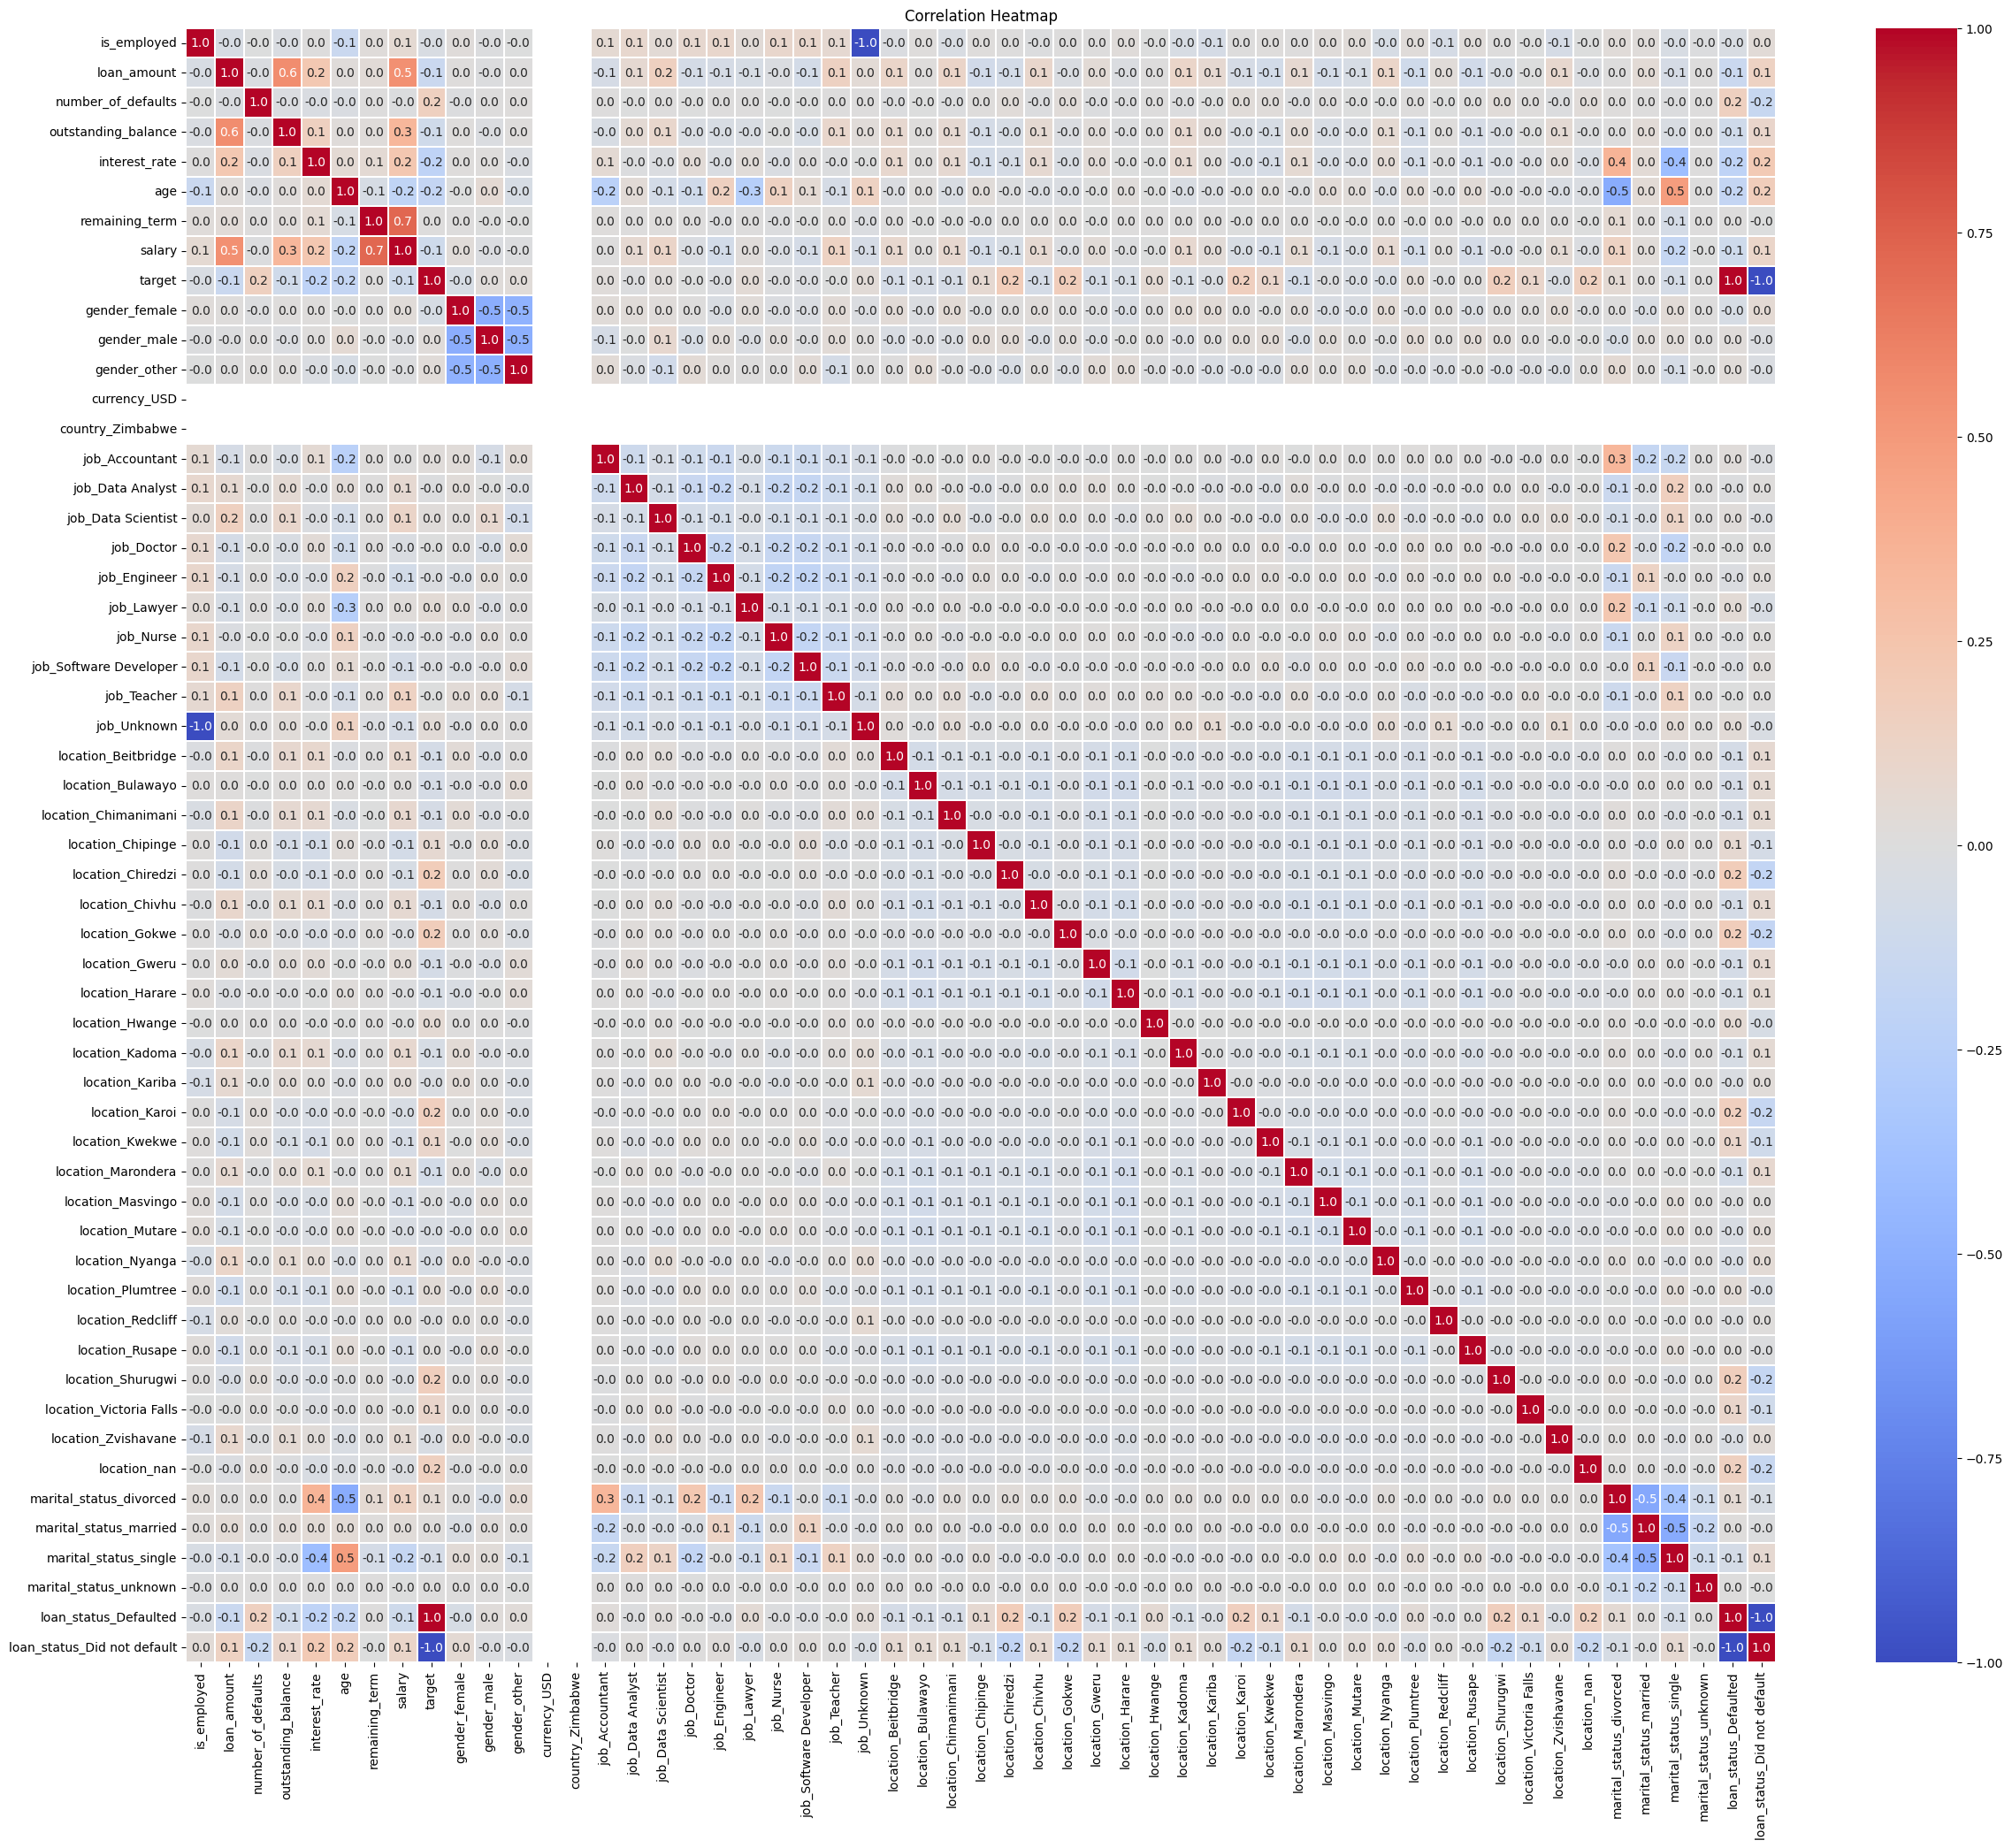

In [17]:
# Calculate correlation matrix
numeric_df = df_encoded.select_dtypes(include=['int64', 'float64', 'bool'])
numeric_df['target'] = df['target']
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(29, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation Heatmap')
plt.show()


In [18]:
# Fill missing values in salary_group with the most frequent value (mode)
df_encoded.fillna(method='ffill', inplace=True)
# Convert disbursement_date to datetime and extract year, month, and day
df_encoded['disbursement_date'] = pd.to_datetime(df_encoded['disbursement_date'])
df_encoded['disbursement_year'] = df_encoded['disbursement_date'].dt.year
df_encoded['disbursement_month'] = df_encoded['disbursement_date'].dt.month
df_encoded['disbursement_day'] = df_encoded['disbursement_date'].dt.day
df_encoded.drop('disbursement_date', axis=1, inplace=True)

C:\Users\usar\AppData\Local\Temp\ipykernel_10348\435234598.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_encoded.fillna(method='ffill', inplace=True)


In [19]:
# Feature Engineering
df_encoded['loan_to_income_ratio'] = df_encoded['loan_amount'] / df_encoded['salary']
df_encoded['interest_rate_per_term'] = df_encoded['interest_rate'] / df_encoded['remaining_term']


In [24]:
# Modify this according to your actual preprocessing steps needed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # numerical_features should be defined
        ('cat', OneHotEncoder(), categorical_features)  # categorical_features should be defined
    ])

In [25]:
selector = SelectKBest(score_func=f_classif, k=10)

In [28]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', selector)])

In [29]:
# Separate features and target
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']
# Fit and transform
X_new = pipeline.fit_transform(X, y)

ValueError: A given column is not a column of the dataframe